# فريق تلافيف 
## ما يتضمنه نظام المعجّم العربي
**أهم ما تمّ عمله حتى الآن**
* منهج تأصيل معجمي موحد يُبقي القسم الكلامي للكلمة (التوكن) على قسمه النحوي دون تغيير
* تركنا التشكيل على الكلمات التي عليها تشكيل من الأساس لغرض متابعة العمل على تطوير التصحيح، وإلا فلو أُزيلت لربما كان التفريق والمتجهات أكثر دقة
* إمكانية تحسين نموذج الشَّبكات العصبِيَّة المتكَرّرة بشبكات الذَّاكرة القصيرةِ-الطَّويلةِ المدى بدلا من نموذج الحقول العشوائية المشروطة
* إمكانية تحسين نموذج حقيبية الكلمات المستمرة بدلا من تخطي الكلمة، وذلك بزيادة حجم البيانات 
* استخراج الكلمات ذات العلاقة بنموذج حقيبة الكلمات المستمرة
* استخراج الكلمات المختلفة سياقيا والمتشابة/المتقابة إملائيا بنموذج بيرت 
* اعتمدنا على نموذج مدرب مسبقا لبيرت، ويحتاج بناؤه من الصفر وتدريبه وفق التعلم الموجه وقتا أطول. لاحظنا أن في النمذج المدرّب مسبقا بعض الأخطاء في نظام التفريق، وسنعمل على تحسين ذلك ببناء نظام للتفريق ثم بناء نموذج بيرت بناء عليه على بياناتنا مباشرة

# النماذج على الترتيب مكتوبة بالإنجليزية بغية الوضوح

All models are saved in a zip folder named as NLPiffy_GUI
1. CRF Model: (crf_model.sav)
2. RNN (LSTM) Model: (rnn-model.h5)
3. N-Gram Model: (tag2index.pkl and word2index.pkl)
4. Skip-Gram Model: (model.pt)
5. CBOW Model: (model.h5 and embeddings.npz)
6. Pretrained BERT Model (bert-model.h5)
7. BERT: (tokenized_text.npz) and (token_vecs_cat_array.npz) and (tokenized_text.pkl). All are integrated into the GUI. We created the mdoel bert-model.h5 first, then we created a list of embeddings to use it at this stage. 

### N.B. To execute the user interface, kindly run the code source file named as nlpiffy_gui.py in the the zip folder named as NLPiffy_GUI.

### إرشادات مفيدة حول ترميز الملفات النصية
For easying the encoding: Save TXT files as ANSI encoded if you use jupyter notebook. Save TXT files as UTF-8-Bom encoded if you use colab. Save any TXT files other than our data for to be used in the GUI as UTF-16 encoded. 

In [ ]:
!pip install lazyme

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for lazyme: filename=lazyme-0.0.27-py3-none-any.whl size=8609 sha256=132c8b42ad4422f292e8e675f52e1c6ee6f069e5137b3c953f409d0d7be74c88
  Stored in directory: /root/.cache/pip/wheels/28/09/53/640fc834063c4cd99f669c02e183d2f0e3aa5dfc81cabe215d
Successfully built lazyme


# 1. 1. نموذج الحقول العشوائية المشروطة لتدريب واختبار تصنيف الوسوم النحوية
## Conditional Random Fields (CRF)

In [ ]:
from lazyme import per_section
import nltk 
from collections import Counter
import numpy as np
import pandas as pd

In [ ]:
dataset = pd.read_csv("/content/Talafeef.csv",usecols=['token','tpos'])
dataset.head()

,token,tpos
0,إذا,RP
1,تم,VBD
2,إجراء,N
3,صورة,N
4,شعاعية,N


In [ ]:
dataset.isnull().sum()

token    0
tpos     0
dtype: int64

In [ ]:
dataset['tpos'].apply(lambda x:type(x)).value_counts()

<class 'str'>    61311
Name: tpos, dtype: int64

In [ ]:
#end_sent_index = dataset.query('token=="." or token =="،"').index
end_sent_index = dataset.query('token=="."').index

In [ ]:
sentances=[]
dataset_tuple=[]
for i in dataset.index:
    sentances.append(tuple(dataset.iloc[i,:]))
    if dataset.loc[i,'token'] == '.':
        dataset_tuple.append(sentances)
        sentances=[]

In [ ]:
len(dataset_tuple)

1412

In [ ]:
len(end_sent_index)

1412

In [ ]:
dataset_size = np.arange(len(dataset_tuple))
train_index = np.random.choice(dataset_size, int(len(dataset_tuple)*0.8), replace=False)
test_index = np.setdiff1d(dataset_size,train_index)

In [ ]:
train_index.shape

(1129,)

In [ ]:
test_index.shape

(283,)

In [ ]:
training_sentences = [dataset_tuple[i] for i in train_index]
test_sentences = [dataset_tuple[i] for i in test_index]

In [ ]:
print (training_sentences[0])

[('المادة', 'N'), ('السابعة', 'JJ'), ('و', 'CC'), ('الثلاثون', 'N'), ('يحدد', 'VBP'), ('مجلس', 'N'), ('الوزراء', 'N'), ('بناء', 'N'), ('على', 'IN'), ('اقتراح', 'N'), ('وزير', 'N'), ('الداخلية', 'N'), ('مكافآت', 'N'), ('ل', 'IN'), ('رئيس', 'N'), ('مجلس', 'N'), ('المنطقة', 'N'), ('و', 'CC'), ('أعضائه', 'N'), ('،', 'PUNC'), ('و', 'CC'), ('يراعى', 'VBP'), ('في', 'IN'), ('تقديرها', 'N'), ('تكاليف', 'N'), ('المواصلات', 'N'), ('و', 'CC'), ('الإقامة', 'N'), ('.', 'PUNC')]


In [ ]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        
        'prefix-1': sentence[index][0],
        #'prefix-2': sentence[index][:2],
        #'prefix-3': sentence[index][:3],
        #'prefix-4': sentence[index][:4],
        'suffix-1': sentence[index][-1],
        #'suffix-2': sentence[index][-2:],
        #'suffix-3': sentence[index][-3:],

        'prev_word1': '' if index == 0 else sentence[index - 1],
        
        'next_word1': '' if index == len(sentence) - 1 else sentence[index + 1],        
        
        'is_numeric': sentence[index].isdigit(),
    }

In [ ]:
from nltk.tag.util import untag
# Split the dataset for training and testing
 
def transform_to_dataset(tagged_sentences):
    X, y = [], []
 
    for tagged in tagged_sentences:
        X.append([features(untag(tagged), index) for index in range(len(tagged))])
        y.append([tag for _, tag in tagged])
 
    return X, y
 
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(test_sentences)

print(len(X_train))     
print(len(X_test))

1129
283


In [ ]:
!pip install sklearn_crfsuite

import time
start_time = time.time()

from sklearn_crfsuite import CRF
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
 
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
    c1=0.01,
    c2=0.01,
    max_iterations=100000,
    all_possible_transitions=True)
crf.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 30.3 MB/s 
--- 40.42207884788513 seconds ---


In [ ]:
labels = list(crf.classes_)
labels

['N',
 'JJ',
 'CC',
 'VBP',
 'IN',
 'PUNC',
 'RB',
 'RP',
 'VBD',
 'JJR',
 'DT',
 'WRB',
 'WP',
 'CD',
 'VBN',
 'VB',
 'PRP',
 'ABBREV',
 'FW']

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
a = mlb.fit_transform([crf.classes_])
y_test_matrix = mlb.transform(y_test)
y_pred_matrix = mlb.transform(y_pred)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test_matrix, y_pred_matrix, target_names=crf.classes_, digits=3))

              precision    recall  f1-score   support

           N      1.000     0.815     0.898        27
          JJ      0.996     1.000     0.998       247
          CC      1.000     1.000     1.000        47
         VBP      0.976     0.988     0.982        84
          IN      1.000     0.889     0.941         9
        PUNC      0.996     1.000     0.998       261
          RB      0.958     0.904     0.930       228
          RP      0.917     0.846     0.880        52
         VBD      1.000     1.000     1.000       281
         JJR      1.000     0.979     0.989        48
          DT      1.000     1.000     1.000       283
         WRB      0.989     0.910     0.948       100
          WP      0.976     0.976     0.976       165
          CD      1.000     0.750     0.857        28
         VBN      0.915     0.895     0.905       133
          VB      1.000     0.105     0.190        19
         PRP      0.949     0.959     0.954       196
      ABBREV      0.931    

In [ ]:
import time
start_time = time.time()

from sklearn_crfsuite import metrics
 
y_pred = crf.predict(X_test)
print("Accuracy = ",metrics.flat_accuracy_score(y_test, y_pred))
print ("Recall =", metrics.flat_recall_score(y_test, y_pred, average='weighted',  labels=labels))
print ("Precision =", metrics.flat_precision_score(y_test, y_pred, average='weighted',  labels=labels))
print ("F1 =", metrics.flat_f1_score(y_test, y_pred, average='weighted',  labels=labels))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy =  0.9233107521278444
Recall = 0.9233107521278444
Precision = 0.9220493449340679
F1 = 0.91984520158562
--- 0.1998305320739746 seconds ---


In [ ]:
y_pred = crf.predict(X_test)
print ("F1 =", metrics.flat_f1_score(y_test, y_pred, average='weighted',  labels=labels))

F1 = 0.91984520158562


In [ ]:
sentence = 'إذا تم إجراء صورة شعاعية ل البطن و صورة شعاعية ل الصدر ب وضعية الوقوف و مازال تشخيص استرواح الصفاق غير مؤكد ف عندها يجب طلب تصوير مقطعي محوسب ل البطن .'.split()
def pos_tag(sentence):
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))
 
print(pos_tag(sentence))

[('إذا', 'RP'), ('تم', 'VBD'), ('إجراء', 'N'), ('صورة', 'N'), ('شعاعية', 'N'), ('ل', 'IN'), ('البطن', 'N'), ('و', 'CC'), ('صورة', 'N'), ('شعاعية', 'N'), ('ل', 'IN'), ('الصدر', 'N'), ('ب', 'IN'), ('وضعية', 'N'), ('الوقوف', 'N'), ('و', 'CC'), ('مازال', 'VBD'), ('تشخيص', 'N'), ('استرواح', 'N'), ('الصفاق', 'N'), ('غير', 'N'), ('مؤكد', 'JJ'), ('ف', 'CC'), ('عندها', 'RB'), ('يجب', 'VBP'), ('طلب', 'N'), ('تصوير', 'N'), ('مقطعي', 'JJ'), ('محوسب', 'JJ'), ('ل', 'IN'), ('البطن', 'N'), ('.', 'PUNC')]


# 1. 2. حفظ نموذج الحقول العشوائية المشروطة
## CRF

In [ ]:
import pickle
filename = 'crf_model.sav'
pickle.dump(crf, open(filename, 'wb'))

# 2. 1. نموذج الشبكات العصبية المتكررة (شبكات الذَّاكرة القصيرة-الطويلة المدى)  
## RNN (LSTM)

In [ ]:
!pip install keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dataset = pd.read_csv("/content/Talafeef.csv",usecols=['token','tpos'])
dataset.head()

,token,tpos
0,إذا,RP
1,تم,VBD
2,إجراء,N
3,صورة,N
4,شعاعية,N


In [ ]:
sentances=[]
dataset_tuple=[]
for i in dataset.index:
    sentances.append(tuple(dataset.iloc[i,:]))
    #if dataset.loc[i,'token'] == '.':
    if dataset.loc[i,'token'] == "." or dataset.loc[i,'token'] == "،":
        dataset_tuple.append(sentances)
        sentances=[]

In [ ]:
dataset_tuple[0]

[('إذا', 'RP'),
 ('تم', 'VBD'),
 ('إجراء', 'N'),
 ('صورة', 'N'),
 ('شعاعية', 'N'),
 ('ل', 'IN'),
 ('البطن', 'N'),
 ('و', 'CC'),
 ('صورة', 'N'),
 ('شعاعية', 'N'),
 ('ل', 'IN'),
 ('الصدر', 'N'),
 ('ب', 'IN'),
 ('وضعية', 'N'),
 ('الوقوف', 'N'),
 ('و', 'CC'),
 ('مازال', 'VBD'),
 ('تشخيص', 'N'),
 ('استرواح', 'N'),
 ('الصفاق', 'N'),
 ('غير', 'N'),
 ('مؤكد', 'JJ'),
 ('ف', 'CC'),
 ('عندها', 'RB'),
 ('يجب', 'VBP'),
 ('طلب', 'N'),
 ('تصوير', 'N'),
 ('مقطعي', 'JJ'),
 ('محوسب', 'JJ'),
 ('ل', 'IN'),
 ('البطن', 'N'),
 ('.', 'PUNC')]

In [ ]:
sentences, sentence_tags =[], [] 
for tagged_sentence in dataset_tuple:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(np.array(sentence))
    sentence_tags.append(np.array(tags))

In [ ]:
sentences[2]

array(['و', 'حاليا', 'ف', 'إن', 'معظم', 'المرضى', 'غير', 'المستقرين',
       'الذين', 'يشك', 'لديهم', 'ب', 'استرواح', 'الصفاق', 'يخضعون',
       'مباشرة', 'ل', 'التصوير', 'المقطعي', 'المحوسب', '.'], dtype='<U9')

In [ ]:
sentence_tags[2]

array(['CC', 'N', 'CC', 'RP', 'JJ', 'N', 'N', 'JJ', 'WP', 'VBP', 'RB',
       'IN', 'N', 'N', 'VBP', 'JJ', 'IN', 'N', 'JJ', 'JJ', 'PUNC'],
      dtype='<U4')

In [ ]:
len(sentences[2]), len(sentence_tags[2])

(21, 21)

In [ ]:
(train_sentences, 
 test_sentences, 
 train_tags, 
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

In [ ]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w)
 
for ts in train_tags:
    for t in ts:
        tags.add(t)
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding

In [ ]:
len(word2index)

10665

In [ ]:
tag2index

{'-PAD-': 0,
 'ABBREV': 4,
 'CC': 12,
 'CD': 16,
 'DT': 10,
 'FW': 11,
 'IN': 1,
 'JJ': 14,
 'JJR': 13,
 'N': 5,
 'PRP': 8,
 'PUNC': 6,
 'RB': 17,
 'RP': 18,
 'VB': 3,
 'VBD': 2,
 'VBN': 7,
 'VBP': 9,
 'WP': 19,
 'WRB': 15}

In [ ]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []
 
for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)
 
for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)
 
for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])
 
for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])

In [ ]:
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[6677, 1172, 10390, 3526, 5708, 8686, 2472, 6677, 2472, 1663, 8190, 10390, 7933, 10302, 7126, 7447, 5708, 9413]
[7307, 2284, 6922, 1, 7774, 6622, 6849, 5655, 1, 9989, 5781]
[12, 5, 5, 1, 14, 2, 13, 12, 13, 5, 1, 5, 18, 9, 1, 10, 14, 6]
[5, 14, 18, 2, 5, 5, 5, 1, 5, 5, 6]


In [ ]:
MAX_LENGTH = max([len(s) for s in train_sentences_X])
MAX_LENGTH

2328

In [ ]:
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [ ]:
len(train_sentences_X[0]),len(train_sentences_X[5])

(2328, 2328)

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2328, 128)         1365120   
                                                                 
 bidirectional (Bidirectiona  (None, 2328, 512)        788480    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 2328, 20)         10260     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 2328, 20)          0         
                                                                 
Total params: 2,163,860
Trainable params: 2,163,860
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [ ]:
cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))

In [ ]:
cat_train_tags_y.shape

(2748, 2328, 20)

In [ ]:
model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=40, validation_split=0.2)

Epoch 1/40
18/18 [==============================] - 19s 702ms/step - loss: 0.7100 - accuracy: 0.9344 - val_loss: 0.0564 - val_accuracy: 0.9921
Epoch 2/40
18/18 [==============================] - 12s 657ms/step - loss: 0.0293 - accuracy: 0.9927 - val_loss: 0.0219 - val_accuracy: 0.9937
Epoch 3/40
18/18 [==============================] - 12s 660ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 0.0213 - val_accuracy: 0.9948
Epoch 4/40
18/18 [==============================] - 12s 675ms/step - loss: 0.0219 - accuracy: 0.9949 - val_loss: 0.0193 - val_accuracy: 0.9948
Epoch 5/40
18/18 [==============================] - 12s 680ms/step - loss: 0.0215 - accuracy: 0.9949 - val_loss: 0.0210 - val_accuracy: 0.9949
Epoch 6/40
18/18 [==============================] - 12s 691ms/step - loss: 0.0214 - accuracy: 0.9952 - val_loss: 0.0213 - val_accuracy: 0.9950
Epoch 7/40
18/18 [==============================] - 13s 700ms/step - loss: 0.0208 - accuracy: 0.9951 - val_loss: 0.0211 - val_accuracy: 0.9950

In [ ]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

22/22 [==============================] - 2s 102ms/step - loss: 0.0070 - accuracy: 0.9981
accuracy: 99.80900883674622


In [ ]:
test_samples = [
    "إذا تم إجراء صورة شعاعية ل البطن و صورة شعاعية ل الصدر ب وضعية الوقوف و مازال تشخيص استرواح الصفاق غير مؤكد ف عندها يجب طلب تصوير مقطعي محوسب ل البطن .".split(),
]
print(test_samples)

[['إذا', 'تم', 'إجراء', 'صورة', 'شعاعية', 'ل', 'البطن', 'و', 'صورة', 'شعاعية', 'ل', 'الصدر', 'ب', 'وضعية', 'الوقوف', 'و', 'مازال', 'تشخيص', 'استرواح', 'الصفاق', 'غير', 'مؤكد', 'ف', 'عندها', 'يجب', 'طلب', 'تصوير', 'مقطعي', 'محوسب', 'ل', 'البطن', '.']]


In [ ]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)
 
test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)

[[6922 3827  725 ...    0    0    0]]


In [ ]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[1.2237089e-02 1.7623757e-01 7.3852479e-02 ... 3.2996938e-02
   2.4389674e-01 3.2000016e-02]
  [2.2492858e-02 6.4983331e-02 9.4338037e-02 ... 4.9928263e-02
   1.0135265e-01 3.2800246e-02]
  [4.1396166e-03 1.7557626e-04 7.8985523e-03 ... 3.2530858e-03
   1.4508151e-03 1.6114695e-03]
  ...
  [9.9999535e-01 3.4999655e-08 6.9573531e-08 ... 5.0022533e-07
   6.3232505e-08 4.0307205e-07]
  [9.9999309e-01 5.6562648e-08 9.7366993e-08 ... 7.1040682e-07
   9.6112302e-08 5.8333188e-07]
  [9.9999046e-01 8.2104791e-08 1.2832362e-07 ... 9.4367266e-07
   1.3419591e-07 7.8347671e-07]]] (1, 2328, 20)


In [ ]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [ ]:
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})[0])

['RP', 'JJ', 'N', 'N', 'N', 'IN', 'N', 'CC', 'N', 'N', 'IN', 'N', 'IN', 'N', 'N', 'CC', 'N', 'N', 'N', 'N', 'N', 'N', 'CC', 'JJ', 'JJ', 'N', 'N', 'N', 'N', 'IN', 'N', 'PUNC', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-

In [ ]:
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2328, 128)         1365120   
                                                                 
 bidirectional_1 (Bidirectio  (None, 2328, 512)        788480    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 2328, 20)         10260     
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, 2328, 20)          0         
                                                                 
Total params: 2,163,860
Trainable params: 2,163,860
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=40, validation_split=0.2)

Epoch 1/40
18/18 [==============================] - 17s 750ms/step - loss: 0.6860 - accuracy: 0.9918 - ignore_accuracy: 0.0021 - val_loss: 0.0692 - val_accuracy: 0.9920 - val_ignore_accuracy: 0.0000e+00
Epoch 2/40
18/18 [==============================] - 13s 712ms/step - loss: 0.0577 - accuracy: 0.9922 - ignore_accuracy: 0.0000e+00 - val_loss: 0.0374 - val_accuracy: 0.9921 - val_ignore_accuracy: 0.0000e+00
Epoch 3/40
18/18 [==============================] - 13s 717ms/step - loss: 0.0283 - accuracy: 0.9925 - ignore_accuracy: 0.0963 - val_loss: 0.0230 - val_accuracy: 0.9936 - val_ignore_accuracy: 0.3559
Epoch 4/40
18/18 [==============================] - 13s 710ms/step - loss: 0.0219 - accuracy: 0.9938 - ignore_accuracy: 0.3597 - val_loss: 0.0208 - val_accuracy: 0.9941 - val_ignore_accuracy: 0.3794
Epoch 5/40
18/18 [==============================] - 13s 700ms/step - loss: 0.0202 - accuracy: 0.9943 - ignore_accuracy: 0.3945 - val_loss: 0.0201 - val_accuracy: 0.9945 - val_ignore_accuracy: 

In [ ]:
predictions = model.predict(test_samples_X)
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

[['RP', 'VBP', 'N', 'N', 'N', 'IN', 'N', 'CC', 'N', 'N', 'IN', 'N', 'IN', 'N', 'N', 'CC', 'JJ', 'N', 'N', 'N', 'N', 'JJ', 'CC', 'JJ', 'VBP', 'N', 'N', 'JJ', 'N', 'IN', 'N', 'PUNC', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

# 2. 2. حفظ نموذج الشبكات العصبية التكراراية
## RNN (LSTM)

In [ ]:
# Save RNN Model
model.save("rnn-model.h5")

In [ ]:
import pickle
a_file = open("tag2index.pkl", "wb")
pickle.dump(tag2index, a_file)
a_file.close()

In [ ]:
b_file = open("word2index.pkl", "wb")
pickle.dump(word2index, b_file)
b_file.close()

# 3. 1. نموذج الكلمة إلى متجه (تخطي الكلمة) 
## Word2Vec (Skip-Gram Model)

In [ ]:
# يجب إعادة التشغيل بعد التنصيب
#!pip install allennl
#!pip install --upgrade allennlp
!pip install allennlp==2.5.0
!pip install google-cloud-storag
!pip install overrides
!pip install python-bidi
!pip install arabic_reshape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement google-cloud-storag (from versions: none)
ERROR: No matching distribution found for google-cloud-storag
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement arabic_reshape (from versions: none)
ERROR: No matching distribution found for arabic_reshape


In [ ]:
import math
import random
from collections import Counter
import numpy as np
import torch
import torch.optim as optim
from allennlp.common.file_utils import cached_path
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import LabelField
from allennlp.data.instance import Instance
from allennlp.data.vocabulary import Vocabulary
from allennlp.models import Model
from allennlp.modules.token_embedders import Embedding
from allennlp.training import GradientDescentTrainer
from overrides import overrides
from scipy.stats import spearmanr
from torch.nn import CosineSimilarity
from torch.nn import functional
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
from bidi.algorithm import get_display
import arabic_reshaper

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
@DatasetReader.register("skip_gram")
class SkipGramReader(DatasetReader):
    def __init__(self, window_size=5, vocab: Vocabulary=None):
        """A DatasetReader for reading a plain text corpus and producing instances
        for the SkipGram model.
        When vocab is not None, this runs sub-sampling of frequent words as described
        in (Mikolov et al. 2013).
        """
        super().__init__()
        self.window_size = window_size
        self.reject_probs = None
        if vocab:
            self.reject_probs = {}
            threshold = 1.e-3
            token_counts = vocab._retained_counter['token_in']  # HACK
            total_counts = sum(token_counts.values())
            for _, token in vocab.get_index_to_token_vocabulary('token_in').items():
                counts = token_counts[token]
                if counts > 0:
                    normalized_counts = counts / total_counts
                    reject_prob = 1. - math.sqrt(threshold / normalized_counts)
                    reject_prob = max(0., reject_prob)
                else:
                    reject_prob = 0.
                self.reject_probs[token] = reject_prob

    def _subsample_tokens(self, tokens):
        """Given a list of tokens, runs sub-sampling.
        Returns a new list of tokens where rejected tokens are replaced by Nones.
        """
        new_tokens = []
        for token in tokens:
            reject_prob = self.reject_probs.get(token, 0.)
            if random.random() <= reject_prob:
                new_tokens.append(None)
            else:
                new_tokens.append(token)

        return new_tokens

    @overrides
    def _read(self, file_path: str):
        with open(cached_path(file_path), "r") as text_file:
            for line in text_file:
                tokens = line.strip().split(' ')
                tokens = tokens[:1000000]  # TODO: remove

                if self.reject_probs:
                    tokens = self._subsample_tokens(tokens)
                    print(tokens[:200])  # for debugging

                for i, token in enumerate(tokens):
                    if token is None:
                        continue

                    token_in = LabelField(token, label_namespace='token_in')

                    for j in range(i - self.window_size, i + self.window_size + 1):
                        if j < 0 or i == j or j > len(tokens) - 1:
                            continue

                        if tokens[j] is None:
                            continue

                        token_out = LabelField(tokens[j], label_namespace='token_out')
                        yield Instance({'token_in': token_in, 'token_out': token_out})

In [ ]:
EMBEDDING_DIM = 256
BATCH_SIZE = 256
CUDA_DEVICE = -1

In [ ]:
class SkipGramModel(Model):
    def __init__(self, vocab, embedding_in):
        super().__init__(vocab)
        self.embedding_in = embedding_in
        self.linear = torch.nn.Linear(
            in_features=EMBEDDING_DIM,
            out_features=vocab.get_vocab_size('token_out'),
            bias=False)

    def forward(self, token_in, token_out):
        embedded_in = self.embedding_in(token_in)
        logits = self.linear(embedded_in)
        loss = functional.cross_entropy(logits, token_out)

        return {'loss': loss}

In [ ]:
def get_related(token: str, embedding: Model, vocab: Vocabulary, num_synonyms: int = 10):
    """Given a token, return a list of top N most similar words to the token."""
    token_id = vocab.get_token_index(token, 'token_in')
    token_vec = embedding.weight[token_id]
    cosine = CosineSimilarity(dim=0)
    sims = Counter()

    for index, token in vocab.get_index_to_token_vocabulary('token_in').items():
        sim = cosine(token_vec, embedding.weight[index]).item()
        sims[token] = sim

    return sims.most_common(num_synonyms)

In [ ]:
reader = SkipGramReader()
talafeef = reader.read("/content/Talafeef--Seg.txt")

In [ ]:
talafeef = list(talafeef)
print(len(talafeef))

Your label namespace was 'token_in'. We recommend you use a namespace ending with 'labels' or 'tags', so we don't add UNK and PAD tokens by default to your vocabulary.  See documentation for `non_padded_namespaces` parameter in Vocabulary.
Your label namespace was 'token_out'. We recommend you use a namespace ending with 'labels' or 'tags', so we don't add UNK and PAD tokens by default to your vocabulary.  See documentation for `non_padded_namespaces` parameter in Vocabulary.


613110


In [ ]:
vocab = Vocabulary.from_instances(
    talafeef, min_count={'token_in': 2, 'token_out': 2},max_vocab_size=100000)

building vocab: 100%|##########| 613110/613110 [00:00<00:00, 836551.08it/s]


In [ ]:
data_loader = SimpleDataLoader(talafeef, batch_size=BATCH_SIZE)
data_loader.index_with(vocab)

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 12090 || token_out, Size: 12090 || Non Padded Namespaces: {'*labels', '*tags'}>

In [ ]:
embedding_in = Embedding(num_embeddings=vocab.get_vocab_size('token_in'),
                         embedding_dim=EMBEDDING_DIM)

In [ ]:
model = SkipGramModel(vocab=vocab,
                      embedding_in=embedding_in)

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=data_loader,
    num_epochs=5,
    cuda_device=-1)

In [ ]:
trainer.train()

batch_loss: 9.0359, loss: 8.3660 ||: 100%|##########| 2395/2395 [03:10<00:00, 12.55it/s]
batch_loss: 8.5282, loss: 7.3236 ||: 100%|##########| 2395/2395 [03:10<00:00, 12.56it/s]
batch_loss: 8.2418, loss: 7.1107 ||: 100%|##########| 2395/2395 [03:08<00:00, 12.73it/s]
batch_loss: 7.8829, loss: 6.9388 ||: 100%|##########| 2395/2395 [03:07<00:00, 12.74it/s]
batch_loss: 7.6665, loss: 6.7319 ||: 100%|##########| 2395/2395 [03:07<00:00, 12.75it/s]


{'best_epoch': 4,
 'epoch': 4,
 'peak_gpu_0_memory_MB': 0,
 'peak_worker_0_memory_MB': 7762.578125,
 'training_duration': '0:15:45.638961',
 'training_gpu_0_memory_MB': 0.0,
 'training_loss': 6.731911621213208,
 'training_worker_0_memory_MB': 7762.578125}

# 3. 2. حفظ نموذج تخطي الكلمة
## Save Skip-Gram Model

In [ ]:
torch.save(model, r"model.pt")
#with open("model.th", 'wb') as f:
#    torch.save(model.state_dict(), f)
#trainer.save('model.pt')

In [ ]:
print(get_related('العلوم', embedding_in, vocab))

[('العلوم', 1.0), ('تعليم', 0.8703458309173584), ('تهيئتهم', 0.8677076101303101), ('المركب', 0.8643361330032349), ('الوعي', 0.8529304265975952), ('الكل', 0.8455668687820435), ('ثلاثية', 0.8421645760536194), ('الخاص', 0.8407478928565979), ('الألعاب', 0.8403605818748474), ('العلاقة', 0.834192156791687)]


In [ ]:
print(get_related('محمد', embedding_in, vocab))

[('محمد', 1.0), ('بارك', 0.8042806386947632), ('آله', 0.7744510769844055), ('رسولك', 0.7617561221122742), ('إبراهيم', 0.7550841569900513), ('عبدك', 0.7187423706054688), ('نبينا', 0.7112937569618225), ('الطيبين', 0.6969441771507263), ('صلاة', 0.6964487433433533), ('صل', 0.6893997192382812)]


In [ ]:
print(get_related('السعودية', embedding_in, vocab))

[('السعودية', 1.0), ('المملكة', 0.8419516682624817), ('العربية', 0.8219259977340698), ('ملك', 0.7469283938407898), ('سعود', 0.7212409973144531), ('عبدالعزيز', 0.6923967003822327), ('آل', 0.6765409708023071), ('أبناء', 0.6562789082527161), ('الأبناء', 0.6506900191307068), ('الحكم', 0.6470296382904053)]


In [ ]:
print(get_related('النظام', embedding_in, vocab))

[('النظام', 1.0), ('أحكام', 0.8008222579956055), ('تعديل', 0.7748287320137024), ('الأساسي', 0.7551246285438538), ('الرسمية', 0.7481204867362976), ('يبين', 0.7254105806350708), ('السابعة', 0.7229307889938354), ('الجريدة', 0.7176322340965271), ('اختصاصاته', 0.716096818447113), ('المهام', 0.710679829120636)]


In [ ]:
print(get_related('الشباب', embedding_in, vocab))

[('الشباب', 1.0), ('المهارة', 0.8627843856811523), ('التحديث', 0.8342819213867188), ('مطلوبة', 0.8311996459960938), ('المطلوبة', 0.8283560872077942), ('التوجه', 0.8272581696510315), ('مهارات', 0.8234136700630188), ('نظراً', 0.8229364156723022), ('التحوُّل', 0.8224726915359497), ('المشكلات', 0.8198213577270508)]


In [ ]:
token_id = vocab.get_token_index("الله", 'token_in')
token_vec = embedding_in.weight[token_id]

In [ ]:
cosine = CosineSimilarity(dim=0)

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 12090 || token_out, Size: 12090 || Non Padded Namespaces: {'*labels', '*tags'}>

In [ ]:
import numpy as np
np.unique(np.array(talafeef))

array(['token_in', 'token_out'], dtype='<U9')

In [ ]:
len(talafeef)

613110

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 12090 || token_out, Size: 12090 || Non Padded Namespaces: {'*labels', '*tags'}>

In [ ]:
vocab.get_token_to_index_vocabulary('token_in').items()

dict_items([('@@PADDING@@', 0), ('@@UNKNOWN@@', 1), ('و', 2), ('،', 3), ('ب', 4), ('ل', 5), ('.', 6), ('في', 7), ('من', 8), ('على', 9), ('أن', 10), ('الله', 11), ('ف', 12), ('ما', 13), ('لا', 14), ('إلى', 15), (':', 16), ('المادة', 17), ('عن', 18), ('أو', 19), ('هذا', 20), ('التي', 21), ('ذلك', 22), ('مجلس', 23), ('إن', 24), ('-', 25), ('هو', 26), ('كل', 27), ('هذه', 28), (')', 29), ('عليه', 30), ('(', 31), ('مع', 32), ('الصورة', 33), ('الأمعاء', 34), ('اللهم', 35), ("''", 36), ('الذي', 37), ('بعد', 38), ('قد', 39), ('النظام', 40), ('الوزراء', 41), ('له', 42), ('إلا', 43), ('هي', 44), ('/', 45), ('الملك', 46), ('قال', 47), ('كما', 48), ('تظهر', 49), ('سلم', 50), ('إذا', 51), ('كان', 52), ('رئيس', 53), ('صلى', 54), ('بين', 55), ('يكون', 56), ('ك', 57), ('المجلس', 58), ('أكثر', 59), ('الدولة', 60), ('حيث', 61), ('أي', 62), ('شكل', 63), ('المنطقة', 64), ('الهيئة', 65), ('غير', 66), ('البطن', 67), ('تكون', 68), ('أنه', 69), ('يا', 70), ('الذين', 71), ('لم', 72), ('العمل', 73), ('خلال', 74)

In [ ]:
get_related("محمد",embedding_in,vocab)

[('محمد', 1.0),
 ('بارك', 0.8042806386947632),
 ('آله', 0.7744510769844055),
 ('رسولك', 0.7617561221122742),
 ('إبراهيم', 0.7550841569900513),
 ('عبدك', 0.7187423706054688),
 ('نبينا', 0.7112937569618225),
 ('الطيبين', 0.6969441771507263),
 ('صلاة', 0.6964487433433533),
 ('صل', 0.6893997192382812)]

In [ ]:
vocab.get_vocab_size("token_out")

12090

In [ ]:
embedding_in.weight.shape

torch.Size([12090, 256])

# 4. 1. نموذج الكلمة إلى متجه (حقيبة الكلمات المستمرة)
## Word2Vec (CBOW model)

In [ ]:
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import Counter

In [ ]:
data=open("/content/Talafeef--Seg.txt",'r')
talafeef_data = [text for text in data if text.count(' ') >= 2]

In [ ]:
talafeef_data[0]

'\ufeffإذا تم إجراء صورة شعاعية ل البطن و صورة شعاعية ل الصدر ب وضعية الوقوف و ما مازال تشخيص استرواح الصفاق غير مؤكد ف عندها يجب طلب تصوير مقطعي محوسب ل البطن . يعرِّض التصوير المقطعي المحوسب المريض ل كمية أكبر من الإشعاع لكنه سيُظهر ب وضوح وجود الغاز ( السهم الأبيض ) و قد يشخص السبب المستبطن . و حاليا ف إن معظم المرضى غير المستقرين الذين يشك لديهم ب استرواح الصفاق يخضعون مباشرة ل التصوير المقطعي المحوسب . 24 أ A D مثال 2 مثال 3 الصورة 24 : صورتان شعاعيتان ل البطن متطابقتان تظهران استرواح صفاق كبير . يوجد عرى معوية يحددها خارجياً غاز من كلا الجانبين ب شكل يتوافق مع علامة Rigler . تظهر الصورة اليمنى المناطق التي تكون فيها علامة Rigler أكثر وضوحاً ب لون بني و فيروزي لمعة الأمعاء معلَّمة ب لون بني أما الغاز الحر الذي يحدد جدار الأمعاء خارجياً معلَّم ب لون فيروزي صورتان شعاعيتان متطابقتان تظهران استرواح صفاق كبير . يوجد عرى معوية يحددها خارجياً غاز من كلا الجانبين ب شكل يتوافق مع علامة Rigler تظهر الصورة اليمنى المناطق حيث يكون استرواح الصفاق أكثر وضوحاً ب اللون الفيروزي و لمعة الأمعاء مع

In [ ]:
vectorize = Tokenizer()
vectorize.fit_on_texts(talafeef_data)
talafeef_data = vectorize.texts_to_sequences(talafeef_data)
total_vocab = sum(len(s) for s in talafeef_data)
word_count = len(vectorize.word_index) + 1
window_size = 2

In [ ]:
word_count

12062

In [ ]:
total_vocab

58922

In [ ]:
def cbow_model(data, window_size, total_vocab):
    total_length = window_size*2
    for text in data:
        text_len = len(text)
        for idx, word in enumerate(text):
            context_word = []
            target   = []            
            begin = idx - window_size
            end = idx + window_size + 1
            context_word.append([text[i] for i in range(begin, end) if 0 <= i < text_len and i != idx])
            target.append(word)
            contextual = sequence.pad_sequences(context_word, maxlen=total_length)
            final_target = np_utils.to_categorical(target, total_vocab)
            yield(contextual, final_target)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_vocab, output_dim=100, input_length=window_size*2))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(100,)))
model.add(Dense(total_vocab, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
for i in range(10):
    cost = 0
    for x, y in cbow_model(talafeef_data, window_size, total_vocab):
        cost += model.train_on_batch(x, y)
    print(i, cost)

0 530570.9163289219
1 481791.86071022507
2 432757.722090774
3 384378.95389958844
4 339999.2241014193
5 300077.1156449679
6 265484.5685823196
7 235058.32053174727
8 209299.7398117776
9 186688.88426344536


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4, 100)            5892200   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 58922)             5951122   
                                                                 
Total params: 11,843,322
Trainable params: 11,843,322
Non-trainable params: 0
_________________________________________________________________


# 4. 2. حفظ نموذج حقيبة الكلمات المستمرة
## Save CBOW Model 

In [ ]:
model.save("model.h5")

In [ ]:
weights = model.get_weights()[0]
w2v_my = {}

for word, index in vectorize.word_index.items():
    w2v_my[word] = weights[index]

np.savez('embeddings.npz', **w2v_my)
embeddings = np.load('embeddings.npz')

In [ ]:
embeddings["الله"]

array([ 0.61085445, -0.3473577 , -0.03837349,  0.5178823 , -0.44165492,
        1.4194641 ,  1.0184125 ,  0.1643308 , -0.52649873,  0.11873528,
        0.8630134 ,  0.428407  , -0.620837  , -0.7565136 , -0.5798327 ,
       -0.14858058, -0.4684286 ,  0.61476576, -1.5827122 , -0.5327583 ,
       -0.17578924,  0.28953943, -1.0736392 ,  0.6434917 , -0.2503405 ,
       -0.73206234, -0.37683937, -0.08265284, -0.0543551 , -0.03336931,
       -0.31910607,  0.92972016, -0.25726223,  0.05296938, -0.29538184,
        0.16251603, -0.34442586,  0.49324003, -0.11371144,  2.9797444 ,
        0.64736533,  0.00978654, -2.254045  , -0.43161562, -0.20004691,
       -0.10406502,  0.07856353, -0.83750546, -1.5034993 ,  0.3268604 ,
        0.08706588,  0.6089011 ,  0.18564135, -0.14498538,  0.4643759 ,
        0.24588332,  2.6581457 , -0.34791744, -0.3775428 , -0.37810978,
       -0.5432113 ,  0.05284639, -0.06624154,  1.679261  , -0.7838164 ,
       -1.2501003 ,  0.9766537 , -1.9887371 ,  0.19468023, -0.82

In [ ]:
def get_related(token: str, num_synonyms: int = 10):
    """Given a token, return a list of top N most similar words to the token."""
    token_vec = w2v_my[token]
    sims = Counter()

    for w,vec in w2v_my.items():
        sim = np.dot(token_vec, vec)/(np.linalg.norm(token_vec) * np.linalg.norm(vec))
        sims[w] = sim

    return sims.most_common(num_synonyms)

In [ ]:
get_related("أشعة",10)

[('أشعة', 1.0000001),
 ('1633', 0.47128224),
 ('وفاة', 0.4216468),
 ('قطراً', 0.40682098),
 ('تحاليلها', 0.3893463),
 ('قراراتها', 0.37951475),
 ('يصاب', 0.37922612),
 ('المنعم', 0.37320325),
 ('يتحرى', 0.37302536),
 ('القطني', 0.3678385)]

In [ ]:
get_related("مرض",10)

[('مرض', 1.0000001),
 ('haustra', 0.5833569),
 ('الداء', 0.5775673),
 ('القرحي', 0.562282),
 ('المستقيمي', 0.5458181),
 ('الهضمي', 0.5454402),
 ('العدوى', 0.53889304),
 ('شديد', 0.53297436),
 ('الاربعاء', 0.5266541),
 ('carcinma', 0.5222061)]

In [ ]:
get_related("التقنية",10)

[('التقنية', 1.0),
 ('مهارات', 0.56625545),
 ('الطباعة', 0.5506914),
 ('data', 0.5433215),
 ('تجريد', 0.52403504),
 ('خبرة', 0.5223622),
 ('الحرة', 0.5167992),
 ('الحصيّن', 0.5163411),
 ('المستقبلية', 0.50818413),
 ('العشرين', 0.5064001)]

In [ ]:
np.array(list(w2v_my.values())).shape

(12061, 100)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
from bidi.algorithm import get_display
import arabic_reshaper

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(np.array(list(w2v_my.values())))

In [ ]:
arabic_stopwords = stopwords.words("arabic")
w2v_my_no_stop=dict()
for key,value in w2v_my.items():
  if key not in arabic_stopwords:
    w2v_my_no_stop[key]=value

Text(0, 0.5, 'PCA2')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


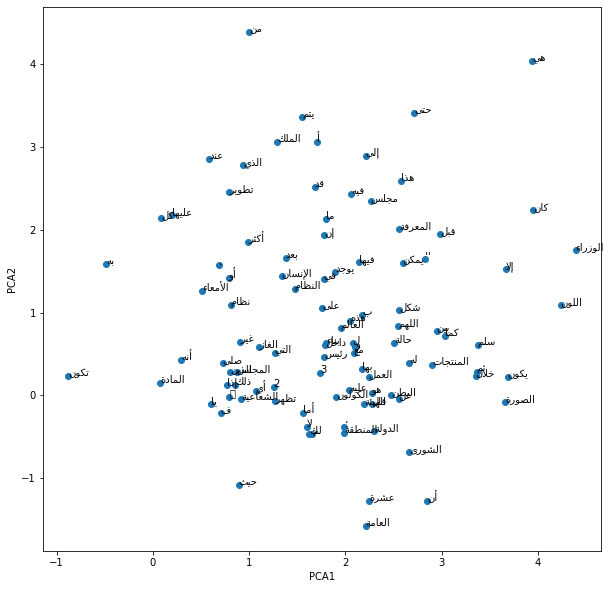

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(np.array(list(w2v_my_no_stop.values())))
plt.figure(figsize=(10,10))
labels= list(embeddings.keys())[:100]
plt.scatter(pca_components[:100,0],pca_components[:100,1],cmap='plasma')
for i in range(100):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# 5. BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 61.9 MB/s 
     |████████████████████████████████| 6.6 MB 51.1 MB/s 
     |████████████████████████████████| 86 kB 5.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import logging
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")


Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
model = AutoModel.from_pretrained("asafaya/bert-base-arabic", output_hidden_states=True)

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with open('/content/Talafeef--Seg.txt', 'r') as f:
  text = f.read()

In [ ]:
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'اذا', 'تم', 'اجراء', 'صورة', 'شع', '##اعية', 'ل', 'البطن', 'و', 'صورة', 'شع', '##اعية', 'ل', 'الصدر', 'ب', 'وضعية', 'الوقوف', 'و', 'ما', 'مازال', 'تشخيص', 'استر', '##واح', 'الصفا', '##ق', 'غير', 'موك', '##د', 'ف', 'عندها', 'يجب', 'طلب', 'تصوير', 'مقطع', '##ي', 'محو', '##سب', 'ل', 'البطن', '.', 'يعرض', 'التصوير', 'المقطع', '##ي', 'المح', '##وس', '##ب', 'المريض', 'ل', 'كمية', 'اكبر', 'من', 'الاشع', '##اع', 'لكنه', 'سي', '##ظهر', 'ب', 'وضوح', 'وجود', 'الغاز', '(', 'السهم', 'الابيض', ')', 'و', 'قد', 'يش', '##خص', 'السبب', 'المستب', '##طن', '.', 'و', 'حاليا', 'ف', 'ان', 'معظم', 'المرضى', 'غير', 'المستق', '##رين', 'الذين', 'يشك', 'لديهم', 'ب', 'استر', '##واح', 'الصفا', '##ق', 'يخضع', '##ون', 'مباشرة', 'ل', 'التصوير', 'المقطع', '##ي', 'المح', '##وس', '##ب', '.', '24', 'ا', 'a', 'd', 'مثال', '2', 'مثال', '3', 'الصورة', '24', ':', 'صور', '##تان', 'شع', '##اعي', '##تان', 'ل', 'البطن', 'متط', '##ابق', '##تان', 'تظهر', '##ان', 'استر', '##واح', 'صفا', '##ق', 'كبير', '.', 'يوجد', 'عر', '#

In [ ]:
splitted_text = text.split(".")
marked_text=''
for sent in splitted_text:
  marked_text = marked_text +  "[CLS] " + sent + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

Streaming output truncated to the last 5000 lines.
محلل         14,415
##ة           1,012
الانظمة      10,654
و               251
البرامج       3,604
في            1,725
الادارة       3,635
الاستراتيجية  8,176
و               251
تحليل         8,027
الاسواق       7,173
في            1,725
ارام         25,371
##كو          2,673
السعودية      2,430
الاستاذة     21,665
سوز          12,236
##ان          1,721
العمري       24,177
،               219
و               251
جاء           3,060
فيها          2,307
ان            1,732
هذه           1,911
المهارات     12,692
تنق          25,472
##سم          1,789
الى           1,774
قسمين        30,976
:                30
مهارات        9,003
تقنية         5,941
،               219
و               251
مهارات        9,003
انسانية      12,250
[SEP]             3
[CLS]             2
و               251
ذكرت          8,053
ان            1,732
اج            2,079
##ادة         1,932
استخدام       2,797
التقنية       4,976
من            1,726
تصميم    

In [ ]:
segments_ids=[]
id=0
for i in tokenized_text:
  if i != '[SEP]':
    segments_ids.append(id)
  else:
    segments_ids.append(id)
    id = id + 1

In [ ]:
import math
chunks = math.ceil(len(tokenized_text)/512)

In [ ]:
tokens_tensor = torch.tensor([indexed_tokens[:512]])
segments_tensor = torch.tensor([segments_ids[:512]])

In [ ]:
'''
# Convert inputs to PyTorch tensors
for i in range(chunks):
  tokens_tensor = torch.tensor([indexed_tokens[i*512:(i+1)*512]])
  segments_tensor = torch.tensor([segments_ids[i*512:(i+1)*512]])
  if i == chunks:
    tokens_tensor = torch.tensor([indexed_tokens[i*512:]])
    segments_tensor = torch.tensor([segments_ids[i*512:]])
  
  model.eval()
  with torch.no_grad():
    outputs = model(tokens_tensor,segments_tensor)
    hidden_states = outputs[2]
  
  print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
  layer_i = 0

  print ("Number of batches:", len(hidden_states[layer_i]))
  batch_i = 0

  print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
  token_i = 0

  print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

  token_embeddings = torch.stack(hidden_states, dim=0)

  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)
  # Stores the token vectors, with shape [22 x 768]
  token_vecs_sum = []

# `token_embeddings` is a [512 x 12 x 768] tensor.

# For each token in the sentence...
  for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

    print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))
'''

'\n# Convert inputs to PyTorch tensors\nfor i in range(chunks):\n  tokens_tensor = torch.tensor([indexed_tokens[i*512:(i+1)*512]])\n  segments_tensor = torch.tensor([segments_ids[i*512:(i+1)*512]])\n  if i == chunks:\n    tokens_tensor = torch.tensor([indexed_tokens[i*512:]])\n    segments_tensor = torch.tensor([segments_ids[i*512:]])\n  \n  model.eval()\n  with torch.no_grad():\n    outputs = model(tokens_tensor,segments_tensor)\n    hidden_states = outputs[2]\n  \n  print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")\n  layer_i = 0\n\n  print ("Number of batches:", len(hidden_states[layer_i]))\n  batch_i = 0\n\n  print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))\n  token_i = 0\n\n  print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))\n\n  token_embeddings = torch.stack(hidden_states, dim=0)\n\n  token_embeddings = torch.squeeze(token_embeddings, dim=1)\n  token_embeddings = token_embeddings.permute(1,0

In [ ]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
len(tokenized_text)

72527

In [ ]:
len(segments_ids)

72527

In [ ]:
with torch.no_grad():
    outputs = model(tokens_tensor,segments_tensor)
    hidden_states = outputs[2]

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))


Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 512
Number of hidden units: 768


In [ ]:
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 512, 768])


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 512, 768])

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 512, 768])

In [ ]:
torch.Size([13, 22, 768])

torch.Size([13, 22, 768])

In [ ]:
hidden_states[0].shape

torch.Size([1, 512, 768])

In [ ]:
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([512, 13, 768])

In [ ]:
torch.Size([22, 13, 768])

torch.Size([22, 13, 768])

In [ ]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [512 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))


Shape is: 512 x 768


In [ ]:
np.array(token_vecs_sum).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(512,)

In [ ]:
token_vecs_cat_array=np.empty((512,3072),float)
for t in token_vecs_sum:
  np.append(token_vecs_cat_array,np.array(t))
token_vecs_cat_array.shape

(512, 3072)

In [ ]:
token_vecs_cat_array[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.38099977e-17, 8.36244128e-19, 5.84019389e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.00601596e-12, 1.77063274e-09, 2.33785486e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.86250031e-24, 3.26018563e-37, 5.78121283e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.14509942e-27, 3.99577510e-31, 4.26116970e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.12235412e-26, 1.86218802e-30, 1.13588133e-20]])

In [ ]:
def get_related(token: str, num_synonyms: int = 10):
    """Given a token, return a list of top N most similar words to the token."""
    token_vec = token_vecs_cat_array[tokenized_text.index(token)]
    sims = Counter()

    for i in range (512):
        sim = np.dot(token_vec, token_vecs_cat_array[i])/(np.linalg.norm(token_vec) * np.linalg.norm(token_vecs_cat_array[i]))
        sims[tokenized_text[i]] = sim

    return sims.most_common(num_synonyms)

In [ ]:
get_related("الغاز",10)

[('##اع', 0.5612088952114074),
 ('الوقوف', 0.3740995340785247),
 ('##سب', 0.06349891684147983),
 ('مقطع', 0.0422104753279046),
 ('لكنه', 0.02538152918483546),
 ('وضعية', 0.018298273631827216),
 ('وجود', 0.008099020168423666),
 ('حاليا', 0.007928442632898072),
 ('يجب', 0.007308108379814646),
 ('الصدر', 0.007259996384121925)]

In [ ]:
get_related("مقطع",10)

[('مقطع', 1.0000000000000002),
 ('ما', 0.10589746091675196),
 ('يمكنك', 0.03872304875459284),
 ('اسهم', 0.03822773053040653),
 (')', 0.03445339188035112),
 ('##ig', 0.030831980459345203),
 ('المريض', 0.02683330101691659),
 ('##واح', 0.024022615266366867),
 ('تشخيص', 0.019013642902695596),
 ('عروة', 0.01624117865148541)]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(token_vecs_cat_array)

In [ ]:
! pip install python-bidi
! pip install arabic-reshaper
from bidi.algorithm import get_display
import arabic_reshaper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0, 0.5, 'PCA2')

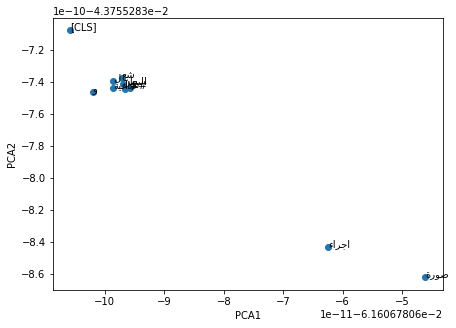

In [ ]:
plt.figure(figsize=(7,5))
labels=tokenized_text
plt.scatter(pca_components[:10,0],pca_components[:10,1],cmap='plasma')
for i in range(10):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")


In [ ]:
torch.save(model,'bert-model.h5')

In [ ]:
token_vecs_cat_array
print(type(token_vecs_cat_array))

<class 'numpy.ndarray'>


In [ ]:
tokenized_text
print(type(tokenized_text))

<class 'list'>


In [ ]:
np.savez('token_vecs_cat_array.npz', token_vecs_cat_array)
np.savez('tokenized_text.npz', tokenized_text)

In [ ]:
token_vecs_cat_array2 = np.load('token_vecs_cat_array.npz')
tokenized_text2 = np.load('tokenized_text.npz')
print(token_vecs_cat_array2==token_vecs_cat_array)
print(tokenized_text2==tokenized_text)

False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from numpy import asarray
from numpy import load
from numpy import savez_compressed

In [ ]:
data= load('token_vecs_cat_array.npz')
token_vecs_cat_array2 = data['arr_0']
token_vecs_cat_array2==token_vecs_cat_array

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
savez_compressed('token_vecs_cat_array.npz', token_vecs_cat_array)

In [ ]:
import pickle
open_file = open("tokenized_text.pkl", "wb")
pickle.dump(tokenized_text, open_file)
open_file.close()

In [ ]:
open_file = open("tokenized_text.pkl", "rb")
tokenized_text2 = pickle.load(open_file)
open_file.close()

tokenized_text2==tokenized_text

True